Data Exploration
===

Data exploration and transformation.

Most of the explorations should be self-explanatory or documented via code comments.

Additional comments are provided in the `DataModeling` notebook.

In [1]:
import pathlib
from datetime import datetime, timedelta

import dateutil.relativedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Using Jupyter magic + git to identify the data within the repository
git_root_dir = !git rev-parse --show-toplevel
git_root_dir = pathlib.Path(git_root_dir[0])
data_dir = git_root_dir / "data"
assert data_dir.exists(), f"Expected directory '{data_dir}' to exist."
data_dir

PosixPath('/Users/levoniaz/repos/covid-data-analysis/data')

In [3]:
pdf = pd.read_csv(data_dir / "patients.csv")
edf = pd.read_csv(data_dir / "encounters.csv")
len(pdf), len(edf)

(12352, 321528)

## Patient data

In [4]:
pdf.sample(n=3)

,Id,BIRTHDATE,DEATHDATE,SSN,DRIVERS,PASSPORT,PREFIX,FIRST,LAST,SUFFIX,...,BIRTHPLACE,ADDRESS,CITY,STATE,COUNTY,ZIP,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE
4744,60be16cb-ceef-44b2-a60e-211392c2292a,1982-11-01,NaN,999-16-2246,S99958178,X37174647X,Mr.,Adalberto916,Murazik203,NaN,...,Dartmouth Massachusetts US,166 Witting Annex Suite 41,Chelsea,Massachusetts,Suffolk County,2150.0,42.463206,-70.990271,822237.69,6993.30
2978,b9444dd9-ff71-4fbd-97f5-d29fa211ac8a,1998-10-12,NaN,999-12-3448,S99957868,X72782039X,Ms.,Ninfa662,Jones311,NaN,...,Somerville Massachusetts US,152 Hirthe Trailer Apt 21,Fall River,Massachusetts,Bristol County,2723.0,41.635521,-71.032663,551306.13,3486.40
929,7399ba91-21c7-46cd-bcec-f38f0ff4a049,1973-09-16,NaN,999-22-9908,S99916266,X56469495X,Mrs.,Conchita9,Sisneros410,NaN,...,Juarez Chihuahua MX,286 Mraz Esplanade,Holyoke,Massachusetts,Hampden County,1040.0,42.208556,-72.681496,1017086.68,9629.72


In [5]:
# proportion of missing values; only REASONCODE (and accompanying description) can be missing
pdf.isna().sum(axis=0) / len(pdf)

Id                     0.000000
BIRTHDATE              0.000000
DEATHDATE              0.809585
SSN                    0.000000
DRIVERS                0.158112
PASSPORT               0.202963
PREFIX                 0.181509
FIRST                  0.000000
LAST                   0.000000
SUFFIX                 0.989961
MAIDEN                 0.713407
MARITAL                0.284893
RACE                   0.000000
ETHNICITY              0.000000
GENDER                 0.000000
BIRTHPLACE             0.000000
ADDRESS                0.000000
CITY                   0.000000
STATE                  0.000000
COUNTY                 0.000000
ZIP                    0.457578
LAT                    0.000000
LON                    0.000000
HEALTHCARE_EXPENSES    0.000000
HEALTHCARE_COVERAGE    0.000000
dtype: float64

### Patient birth and death data

In [6]:
pdf["BIRTH"] = pdf.BIRTHDATE.map(lambda date_str: datetime.strptime(date_str, "%Y-%m-%d"))
pdf["DEATH"] = pdf.DEATHDATE.map(
    lambda date_str: datetime.strptime(date_str, "%Y-%m-%d") if pd.notna(date_str) else np.nan
)
pdf["LIFESPAN"] = pdf.DEATH - pdf.BIRTH

In [7]:
# note: data only includes up through the very first wave of COVID hospitalizations and deaths
print(f"{len(pdf)} births range from {pdf.BIRTH.min()} to {pdf.BIRTH.max()}")
print(f"{pdf.DEATH.notna().sum()} deaths range from {pdf.DEATH.min()} to {pdf.DEATH.max()}")
print(
    f"Minimum lifespan is {pdf.LIFESPAN.min().days} days, mean is {pdf.LIFESPAN.mean().days / 365:.1f} years, longest is {pdf.LIFESPAN.max().days / 365:.1f} years"
)

12352 births range from 1909-11-19 00:00:00 to 2020-05-25 00:00:00
2352 deaths range from 1914-02-15 00:00:00 to 2020-05-22 00:00:00
Minimum lifespan is 203 days, mean is 63.5 years, longest is 110.3 years


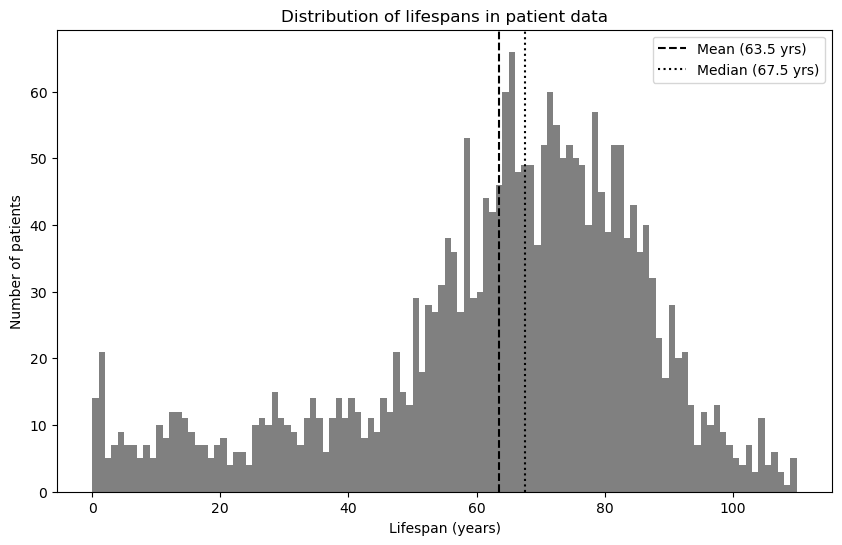

In [8]:
years = pdf[pdf.LIFESPAN.notna()].LIFESPAN.map(lambda td: td.days) / 365
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.hist(years, bins=np.arange(0, 111), color="gray")
ax.axvline(years.mean(), label=f"Mean ({years.mean():.1f} yrs)", color="black", linestyle="--")
ax.axvline(years.median(), label=f"Median ({years.median():.1f} yrs)", color="black", linestyle="dotted")

ax.set_xlabel("Lifespan (years)")
ax.set_ylabel("Number of patients")
ax.set_title("Distribution of lifespans in patient data")
ax.legend()

plt.show()

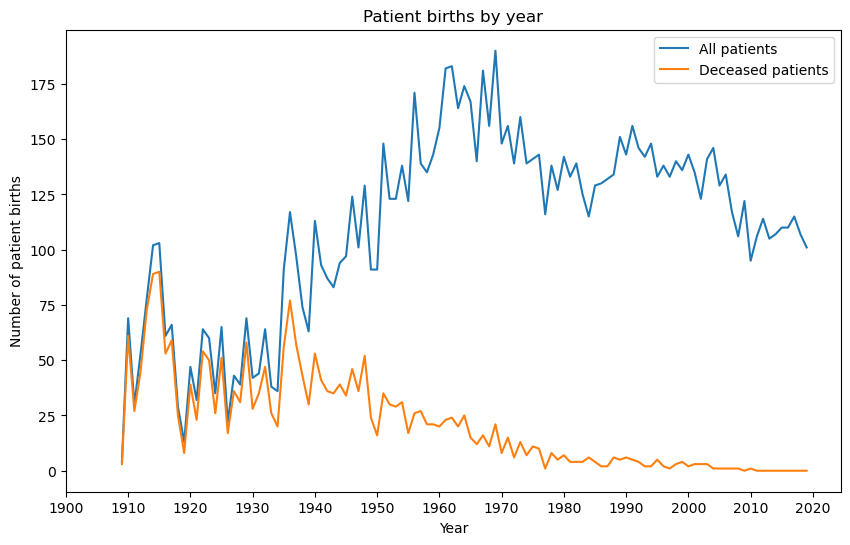

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

bins = [datetime.strptime(str(year), "%Y").timestamp() for year in np.arange(1909, 2021)]
totals, bin_edges = np.histogram(pdf.BIRTH.map(lambda dt: dt.timestamp()), bins=bins)
ax.plot(bin_edges[:-1], totals, label="All patients")
deceased_totals, bin_edges = np.histogram(pdf[pdf.DEATH.notna()].BIRTH.map(lambda dt: dt.timestamp()), bins=bins)
ax.plot(bin_edges[:-1], deceased_totals, label="Deceased patients")


def format_date(x, _):
    return datetime.utcfromtimestamp(x).strftime("%Y")


ax.xaxis.set_major_formatter(format_date)
ax.set_xticks([datetime.strptime(str(year), "%Y").timestamp() for year in np.arange(1900, 2021, 10)])

ax.set_xlabel("Year")
ax.set_ylabel("Number of patient births")
ax.set_title("Patient births by year")
ax.legend()

plt.show()

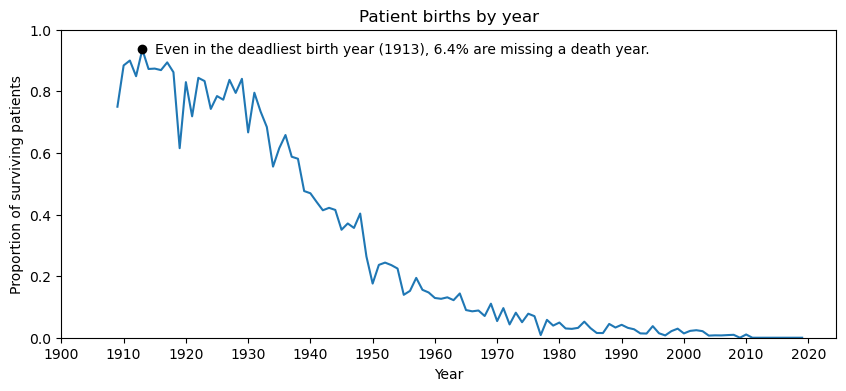

In [10]:
# very likely missing some death data,
# given that a relatively high proportion of patients in 1910-1920 having missing DEATHDATEs.
# at least some patients are living in every year that we have a recorded BIRTHDATE
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.plot(bins[:-1], deceased_totals / totals)
ax.set_ylim((0, 1))

highest_deathrate = (deceased_totals / totals).argmax()
ax.scatter(bins[highest_deathrate], (deceased_totals / totals)[highest_deathrate], color="black", zorder=99)
ax.text(
    bins[highest_deathrate] + 60 * 60 * 24 * 365 * 2,
    (deceased_totals / totals)[highest_deathrate],
    f"Even in the deadliest birth year ({datetime.utcfromtimestamp(bins[highest_deathrate]).strftime('%Y')}), {1 - (deceased_totals / totals)[highest_deathrate]:.1%} are missing a death year.",
    color="black",
    ha="left",
    va="center",
)

ax.set_xlabel("Year")
ax.set_ylabel("Proportion of surviving patients")
ax.set_title("Patient births by year")

ax.xaxis.set_major_formatter(format_date)
ax.set_xticks([datetime.strptime(str(year), "%Y").timestamp() for year in np.arange(1900, 2021, 10)])

plt.show()

1770 death certification encounters. 100% of associated patients have a recorded death date.
Median of 7 days (max 15 days, min 0 days) between recorded patient death date and the Death Certification encounter.
1770 / 2352 patients with recorded death dates have a Death Certification.


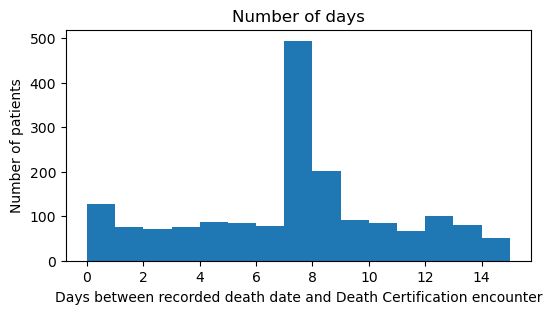

In [11]:
# let's see if we can learn about the missing death dates from the Death Certification encounters
# we don't observe anything useful: every patient with a death certification also has a DEATHDATE
# and there aren't any wild discrepencies between the time of the Death Certification and the recorded death date.
death_certification_code = edf[edf.DESCRIPTION == "Death Certification"].CODE.iloc[0]
death_certs = edf[edf.CODE == death_certification_code].copy()
death_certs = death_certs.merge(pdf, how="left", validate="many_to_one", left_on="PATIENT", right_on="Id")
print(
    f"{len(death_certs)} death certification encounters. {death_certs.DEATH.notna().sum() / len(death_certs):.0%} of associated patients have a recorded death date."
)
certification_times = death_certs.START.map(lambda date_str: datetime.strptime(date_str, "%Y-%m-%dT%H:%M:%SZ"))
cert_death_difference = certification_times - death_certs.DEATH
print(
    f"Median of {cert_death_difference.median().days} days (max {cert_death_difference.max().days} days, min {cert_death_difference.min().days} days) between recorded patient death date and the Death Certification encounter."
)

# check: how many patients with recorded deaths have a death certification?
deceased_patients = pdf[pdf.DEATH.notna()].merge(
    edf[edf.CODE == death_certification_code].copy(),
    how="left",
    validate="one_to_many",
    left_on="Id",
    right_on="PATIENT",
)
print(
    f"{deceased_patients.CODE.notna().sum()} / {len(deceased_patients)} patients with recorded death dates have a Death Certification."
)

# distribution plot reveals most death certifications happen a week after the recorded death
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.hist(cert_death_difference.map(lambda td: td.days), bins=np.arange(0, 16))
ax.set_xlabel("Days between recorded death date and Death Certification encounter")
ax.set_ylabel("Number of patients")
ax.set_title("Number of days")
plt.show()

### Other patient data

In [12]:
pdf.RACE.value_counts(dropna=False)

white     10328
black      1100
asian       842
native       73
other         9
Name: RACE, dtype: int64

In [13]:
pd.crosstab(pdf.RACE, pdf.ETHNICITY).sort_values(by="hispanic", ascending=False)

ETHNICITY,hispanic,nonhispanic
RACE,,
white,1096,9232
black,131,969
asian,75,767
native,12,61
other,2,7


In [14]:
pdf.GENDER.value_counts(dropna=False)

F    6253
M    6099
Name: GENDER, dtype: int64

## Encounter data

In [15]:
edf.nunique()

Id                     321528
START                  293914
STOP                   310103
PATIENT                 12330
ORGANIZATION             5209
PROVIDER                 5214
PAYER                      10
ENCOUNTERCLASS              6
CODE                       48
DESCRIPTION                56
BASE_ENCOUNTER_COST         2
TOTAL_CLAIM_COST            2
PAYER_COVERAGE             15
REASONCODE                 98
REASONDESCRIPTION          99
dtype: int64

In [16]:
edf.sample(n=2)

,Id,START,STOP,PATIENT,ORGANIZATION,PROVIDER,PAYER,ENCOUNTERCLASS,CODE,DESCRIPTION,BASE_ENCOUNTER_COST,TOTAL_CLAIM_COST,PAYER_COVERAGE,REASONCODE,REASONDESCRIPTION
62049,bc7809bf-29a7-4570-be00-47bee69ff920,2009-05-06T11:29:26Z,2009-05-06T11:59:26Z,a74c1171-60eb-4a17-8f7f-6a77a5907d50,1c0908f9-695a-32d9-80d2-eac924de1b99,95e44d3c-a172-38df-b0ee-1bfbe6662395,7c4411ce-02f1-39b5-b9ec-dfbea9ad3c1a,wellness,162673000,General examination of patient (procedure),129.16,129.16,129.16,NaN,NaN
89909,413c8f31-3861-4df8-b87c-6e96c531d0b8,2019-10-15T10:56:47Z,2019-10-15T11:11:47Z,01936601-631d-4f32-b3ab-e70163b6b436,daa4c408-5fc5-32a8-881e-12181e8b8598,c72f406d-186b-34d8-809e-bc7a5df41053,b1c428d6-4f07-31e0-90f0-68ffa6ff8c76,wellness,410620009,Well child visit (procedure),129.16,129.16,0.00,NaN,NaN


In [17]:
# proportion of missing values; only REASONCODE (and accompanying description) can be missing
edf.isna().sum(axis=0) / len(edf)

Id                     0.000000
START                  0.000000
STOP                   0.000000
PATIENT                0.000000
ORGANIZATION           0.000000
PROVIDER               0.000000
PAYER                  0.000000
ENCOUNTERCLASS         0.000000
CODE                   0.000000
DESCRIPTION            0.000000
BASE_ENCOUNTER_COST    0.000000
TOTAL_CLAIM_COST       0.000000
PAYER_COVERAGE         0.000000
REASONCODE             0.778396
REASONDESCRIPTION      0.778396
dtype: float64

In [18]:
edf.ENCOUNTERCLASS.value_counts(dropna=False)

wellness      156219
ambulatory     86069
outpatient     58367
inpatient       9584
emergency       7233
urgentcare      4056
Name: ENCOUNTERCLASS, dtype: int64

In [19]:
edf.DESCRIPTION.value_counts(dropna=False).head()

General examination of patient (procedure)    141988
Encounter for check up (procedure)             50829
Follow-up encounter                            26363
Encounter for symptom                          13599
Encounter for problem                          13250
Name: DESCRIPTION, dtype: int64

In [20]:
# Codes and description are not one-to-one
# some codes have multiple descriptions, so don't rely on the DESCRIPTION field to be unique
description_counts = edf.groupby("CODE").DESCRIPTION.nunique()
multidescription_codes = description_counts[description_counts > 1]
print(f"{multidescription_codes.size} codes have multiple descriptions")
edf.loc[edf.CODE.isin(multidescription_codes.index.values)].groupby(
    ["CODE", "DESCRIPTION"]
).Id.count().reset_index().rename(columns={"Id": "Count"}).sort_values(by=["CODE", "Count"], ascending=False)

5 codes have multiple descriptions


,CODE,DESCRIPTION,Count
11,390906007,Follow-up encounter,26363
12,390906007,Hypertension follow-up encounter,1676
10,185349003,Encounter for check up (procedure),50829
8,185349003,Encounter for 'check-up',2139
9,185349003,Encounter for check up,11
6,185347001,Encounter for problem,13250
7,185347001,Encounter for problem (procedure),10062
5,185347001,Encounter for Problem,769
3,185345009,Encounter for symptom,13599
4,185345009,Encounter for symptom (procedure),9295


In [21]:
# create a dataframe mapping CODE to DESCRIPTION
# the reason this has to be complicated is to deal with the multi-descriptions;
# we want to use the most common descriptor for each code
code_descriptions = (
    edf.groupby(["CODE", "DESCRIPTION"])
    .Id.count()
    .reset_index()
    .rename(columns={"Id": "Count"})
    .sort_values(by=["CODE", "Count"], ascending=False)
    .drop_duplicates(subset="CODE", keep="first")
    .sort_values(by="Count", ascending=False)
    .set_index("CODE")
    .drop(columns="Count")
)
code_descriptions.head(5)

,DESCRIPTION
CODE,
162673000,General examination of patient (procedure)
185349003,Encounter for check up (procedure)
390906007,Follow-up encounter
185345009,Encounter for symptom
185347001,Encounter for problem


In [22]:
edf.CODE.value_counts(dropna=False).head(5).rename("Count").to_frame().merge(
    code_descriptions, how="left", left_index=True, right_index=True
)

,Count,DESCRIPTION
162673000,141988,General examination of patient (procedure)
185349003,52979,Encounter for check up (procedure)
390906007,28039,Follow-up encounter
185347001,24081,Encounter for problem
185345009,22894,Encounter for symptom


In [23]:
# let's look at all the descriptions together
# most codes only occur in a single encounter class
pd.crosstab(edf.DESCRIPTION, edf.ENCOUNTERCLASS, margins=True).sort_values(by="All", ascending=False)

ENCOUNTERCLASS,ambulatory,emergency,inpatient,outpatient,urgentcare,wellness,All
DESCRIPTION,,,,,,,
All,86069,7233,9584,58367,4056,156219,321528
General examination of patient (procedure),0,0,0,0,0,141988,141988
Encounter for check up (procedure),4,0,0,50825,0,0,50829
Follow-up encounter,26363,0,0,0,0,0,26363
Encounter for symptom,13300,0,0,299,0,0,13599
Encounter for problem,10329,0,2576,345,0,0,13250
Well child visit (procedure),0,0,0,0,0,12461,12461
Encounter for problem (procedure),8136,0,6,1920,0,0,10062
Encounter for symptom (procedure),9175,0,120,0,0,0,9295


In [24]:
ct = pd.crosstab(edf.CODE, edf.REASONCODE.notna().rename("REASONCODE_provided")).dropna()
codes_with_complete_REASONCODEs = ct[(ct[False] == 0) & (ct[True] > 0)]
codes_with_partial_REASONCODEs = ct[(ct[False] > 0) & (ct[True] > 0)]
print(
    f"{len(codes_with_complete_REASONCODEs)} (of {len(ct)} total) CODEs have associated REASONCODEs, although reasons are sometimes missing for {len(codes_with_partial_REASONCODEs)} of those encounter codes."
)
codes_with_partial_REASONCODEs.merge(
    code_descriptions, how="left", validate="one_to_one", left_index=True, right_index=True
).sort_values(by=True, ascending=False).rename(columns={False: "No REASONCODE provided", True: "REASONCODE provided"})

24 (of 48 total) CODEs have associated REASONCODEs, although reasons are sometimes missing for 8 of those encounter codes.


,No REASONCODE provided,REASONCODE provided,DESCRIPTION
CODE,,,
390906007,1666,26373,Follow-up encounter
185345009,9396,13498,Encounter for symptom
185347001,15667,8414,Encounter for problem
50849002,2557,2086,Emergency Room Admission
185349003,52463,516,Encounter for check up (procedure)
185389009,1,77,Follow-up visit (procedure)
183495009,3,68,Non-urgent orthopedic admission
305408004,57,2,Admission to surgical department


In [25]:
codes_with_complete_REASONCODEs.merge(
    code_descriptions, how="left", validate="one_to_one", left_index=True, right_index=True
).sort_values(by=True, ascending=False).drop(columns=False).rename(columns={True: "Count"})

,Count,DESCRIPTION
CODE,,
424441002,4427,Prenatal initial visit
424619006,3593,Prenatal visit
183452005,2792,Encounter Inpatient
1505002,1867,Hospital admission for isolation (procedure)
308646001,1770,Death Certification
448337001,1717,Telemedicine consultation with patient
308540004,708,Inpatient stay (finding)
394701000,511,Asthma follow-up
316744009,460,Office Visit


In [26]:
# convert date columns
edf["STARTDATE"] = edf.START.map(lambda date_str: datetime.strptime(date_str, "%Y-%m-%dT%H:%M:%SZ"))
edf["STOPDATE"] = edf.STOP.map(lambda date_str: datetime.strptime(date_str, "%Y-%m-%dT%H:%M:%SZ"))

## Identifying COVID-19 hospitalizations

In [27]:
sdf = edf[edf.REASONDESCRIPTION == "COVID-19"]
sdf.sample(n=5)

,Id,START,STOP,PATIENT,ORGANIZATION,PROVIDER,PAYER,ENCOUNTERCLASS,CODE,DESCRIPTION,BASE_ENCOUNTER_COST,TOTAL_CLAIM_COST,PAYER_COVERAGE,REASONCODE,REASONDESCRIPTION,STARTDATE,STOPDATE
32505,dcca17ae-837b-413f-a77a-670ed98484f7,2020-03-10T17:04:09Z,2020-03-28T23:58:09Z,a27847c8-a587-4f7d-a43e-9cde7aa9df2f,4bdaa4c2-c664-3089-aee2-7137abbad27f,268f1d19-c6d7-31d9-b3dd-b6f2cd7cede7,7c4411ce-02f1-39b5-b9ec-dfbea9ad3c1a,inpatient,1505002,Hospital admission for isolation (procedure),129.16,129.16,69.16,840539006.0,COVID-19,2020-03-10 17:04:09,2020-03-28 23:58:09
64870,1f52ca73-b329-45d0-b7dc-bf9d25bc4b1d,2020-03-06T12:35:39Z,2020-03-25T18:41:39Z,03623a00-6bad-4fc7-9f5a-fbdccaf45ed2,d5117822-5756-389d-9547-891a372d580f,5ed53ed3-568e-3f70-9797-49ebdc4a74e9,7caa7254-5050-3b5e-9eae-bd5ea30e809c,inpatient,1505002,Hospital admission for isolation (procedure),129.16,129.16,89.16,840539006.0,COVID-19,2020-03-06 12:35:39,2020-03-25 18:41:39
198549,ef3baf8e-2286-48b2-a689-6c7cffb7b714,2020-03-22T06:16:06Z,2020-03-29T23:46:06Z,2ea003cb-5626-429b-af6e-477800509d23,f1fbcbfb-fcfa-3bd2-b7f4-df20f1b3c3a4,70aca2db-5180-39a4-abe0-2c5eaffaf74d,6e2f1a2d-27bd-3701-8d08-dae202c58632,inpatient,76464004,Hospital admission for observation (procedure),129.16,129.16,54.16,840539006.0,COVID-19,2020-03-22 06:16:06,2020-03-29 23:46:06
36906,73c6be1e-1483-4b10-999b-b3c218cc560d,2020-03-14T01:51:57Z,2020-03-24T12:38:57Z,86e6a3f7-7e01-4fbd-adcd-6bbd0d0f3b08,5d4b9df1-93ae-3bc9-b680-03249990e558,f59948a6-b07a-3248-9661-60f5924b644b,7c4411ce-02f1-39b5-b9ec-dfbea9ad3c1a,inpatient,305351004,Admission to intensive care unit (procedure),129.16,129.16,69.16,840539006.0,COVID-19,2020-03-14 01:51:57,2020-03-24 12:38:57
308923,06be0b71-bd82-4c46-a87a-afc1d28baa51,2020-03-03T00:02:17Z,2020-03-17T00:13:17Z,2aa1b54f-a099-4f32-95eb-57e54bdf8e09,5e765f2b-e908-3888-9fc7-df2cb87beb58,fb558fe2-f4ce-39c0-8a4a-1f5e84300113,5059a55e-5d6e-34d1-b6cb-d83d16e57bcf,inpatient,1505002,Hospital admission for isolation (procedure),129.16,129.16,59.16,840539006.0,COVID-19,2020-03-03 00:02:17,2020-03-17 00:13:17


In [28]:
# let's look specifically at the encounters with COVID-19 as the given reason
# (we pulled the code here from the sample in the cell above)
sdf = edf[edf.REASONCODE == 840539006]
pd.crosstab(sdf.DESCRIPTION, sdf.ENCOUNTERCLASS)

ENCOUNTERCLASS,inpatient,wellness
DESCRIPTION,,
Admission to intensive care unit (procedure),375,0
Death Certification,0,345
Hospital admission for observation (procedure),134,0
Hospital admission for isolation (procedure),1867,0


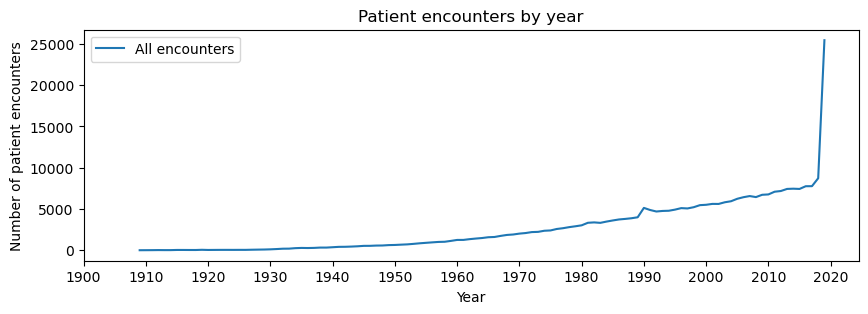

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

bins = [datetime.strptime(str(year), "%Y").timestamp() for year in np.arange(1909, 2021)]
totals, bin_edges = np.histogram(edf.STARTDATE.map(lambda dt: dt.timestamp()), bins=bins)
ax.plot(bin_edges[:-1], totals, label="All encounters")

ax.xaxis.set_major_formatter(format_date)
ax.set_xticks([datetime.strptime(str(year), "%Y").timestamp() for year in np.arange(1900, 2021, 10)])

ax.set_xlabel("Year")
ax.set_ylabel("Number of patient encounters")
ax.set_title("Patient encounters by year")
ax.legend()

plt.show()

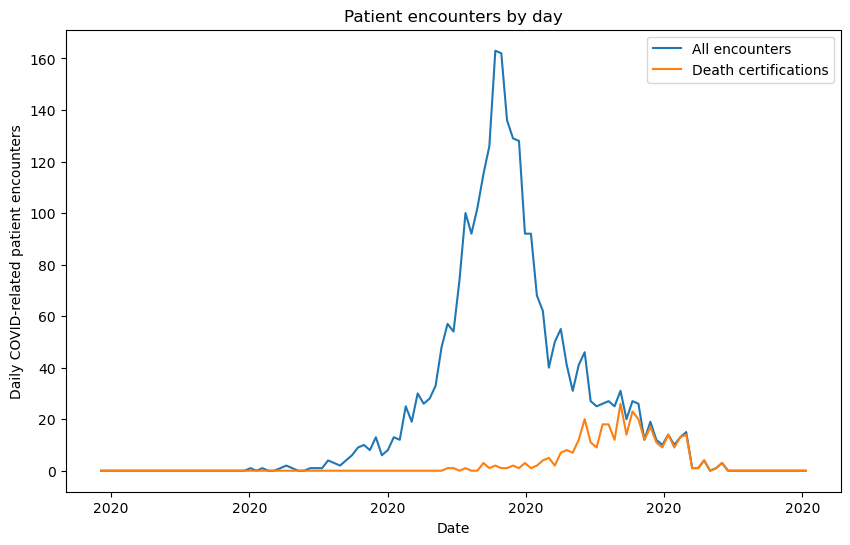

In [30]:
# Start dates on COVID-related encounters seem reasonable
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

bins = [
    (datetime.strptime("2020-01", "%Y-%m") + dateutil.relativedelta.relativedelta(days=i)).timestamp()
    for i in range(120)
]
sdf = edf[edf.REASONCODE == 840539006]
totals, bin_edges = np.histogram(sdf.STARTDATE.map(lambda dt: dt.timestamp()), bins=bins)
ax.plot(bin_edges[:-1], totals, label="All encounters")

certs = sdf[sdf.CODE == 308646001]  # death certifications
totals, bin_edges = np.histogram(certs.STARTDATE.map(lambda dt: dt.timestamp()), bins=bins)
ax.plot(bin_edges[:-1], totals, label="Death certifications")

ax.xaxis.set_major_formatter(format_date)
ax.set_xlabel("Date")
ax.set_ylabel("Daily COVID-related patient encounters")
ax.set_title("Patient encounters by day")
ax.legend()

plt.show()

In [31]:
# I used the list of inpatient encounter codes below
# to generate a list of codes that definitely don't indicate inpatient hospitalization due to COVID-19
nonhospitalization_codes = [310061009, 56876005, 183495009, 305411003, 67799006, 185389009]
edf[edf.ENCOUNTERCLASS == "inpatient"].CODE.value_counts().to_frame().merge(
    code_descriptions, left_index=True, right_index=True
)

,CODE,DESCRIPTION
183452005,2792,Encounter Inpatient
185347001,2582,Encounter for problem
1505002,1867,Hospital admission for isolation (procedure)
308540004,708,Inpatient stay (finding)
305351004,375,Admission to intensive care unit (procedure)
410410006,262,Screening surveillance (regime/therapy)
310061009,168,Gynecology service (qualifier value)
56876005,161,Drug rehabilitation and detoxification
86013001,139,Periodic reevaluation and management of health...
76464004,134,Hospital admission for observation (procedure)


In [32]:
covid_code = 840539006
death_cert_code = 308646001
covid_patients = edf.PATIENT[(edf.REASONCODE == covid_code) & (edf.ENCOUNTERCLASS == "inpatient")]
sdf = edf[(edf.PATIENT.isin(covid_patients)) & (edf.STARTDATE > datetime.strptime("2020-01-01", "%Y-%m-%d"))]
TOLERANCE = dateutil.relativedelta.relativedelta(days=1)

hospitalizations = []
for patient, group in sdf.groupby("PATIENT"):
    group = group.sort_values(by="STARTDATE")
    curr_start = None
    curr_stop = None
    is_covid_death = False
    is_covid_hospitalization = False
    organizations = []
    providers = []
    for encounter in group.itertuples():
        if encounter.ENCOUNTERCLASS == "inpatient" and encounter.CODE not in nonhospitalization_codes:
            organizations.append(encounter.ORGANIZATION)
            providers.append(encounter.PROVIDER)
            if encounter.REASONCODE == covid_code:
                is_covid_hospitalization = True
            if curr_start is None:
                curr_start = encounter.STARTDATE
                curr_stop = encounter.STOPDATE
            elif encounter.STOPDATE > curr_stop and encounter.STOPDATE < curr_stop + TOLERANCE:
                curr_stop = encounter.STOPDATE
            elif curr_stop > curr_stop + TOLERANCE:
                # new hospitalization
                org_counts = pd.Series(organizations).value_counts()
                provider_counts = pd.Series(providers).value_counts()
                hospitalizations.append(
                    {
                        "patient": patient,
                        "startdate": curr_start,
                        "stopdate": curr_stop,
                        "is_covid_hospitalization": is_covid_hospitalization,
                        "is_covid_death": is_covid_death,
                        "n_organizations": len(org_counts),
                        "leading_organization": org_counts.index[0],
                        "n_providers": len(provider_counts),
                        "leading_provider": provider_counts.index[0],
                    }
                )
                curr_start = encounter.STARTDATE
                curr_stop = encounter.STOPDATE
                is_covid_death = False
                is_covid_hospitalization = encounter.REASONCODE == covid_code
                organizations = [
                    encounter.ORGANIZATION,
                ]
                providers = [
                    encounter.PROVIDER,
                ]
        elif encounter.CODE == death_cert_code and encounter.REASONCODE == covid_code:
            assert curr_start is not None
            is_covid_death = True
    if curr_start is not None:
        org_counts = pd.Series(organizations).value_counts()
        provider_counts = pd.Series(providers).value_counts()
        hospitalizations.append(
            {
                "patient": patient,
                "startdate": curr_start,
                "stopdate": curr_stop,
                "is_covid_hospitalization": is_covid_hospitalization,
                "is_covid_death": is_covid_death,
                "n_organizations": len(org_counts),
                "leading_organization": org_counts.index[0],
                "n_providers": len(provider_counts),
                "leading_provider": provider_counts.index[0],
            }
        )
len(hospitalizations)

1867

In [33]:
hdf = pd.DataFrame(hospitalizations)
assert np.all(hdf.stopdate > hdf.startdate)
hdf["duration"] = hdf.stopdate - hdf.startdate
hdf.sample(n=1)

,patient,startdate,stopdate,is_covid_hospitalization,is_covid_death,n_organizations,leading_organization,n_providers,leading_provider,duration
560,4f4285b0-c32b-493c-8116-ca7585deb14c,2020-02-29 08:39:16,2020-03-19 13:42:16,True,False,1,d692e283-0833-3201-8e55-4f868a9c0736,1,a1930239-6238-3656-bdc8-3b249dbac34e,19 days 05:03:00


In [34]:
# validation: no non-COVID hospitalizations
pd.crosstab(hdf.is_covid_hospitalization, hdf.is_covid_death, margins=True)

is_covid_death,False,True,All
is_covid_hospitalization,,,
True,1522,345,1867
All,1522,345,1867


In [35]:
# this approach results in zero patients with multiple hospitalizations
hdf.groupby("patient").startdate.count().value_counts()

1    1867
Name: startdate, dtype: int64

Duration (days): median 14.0, min 1.0, max 21.5


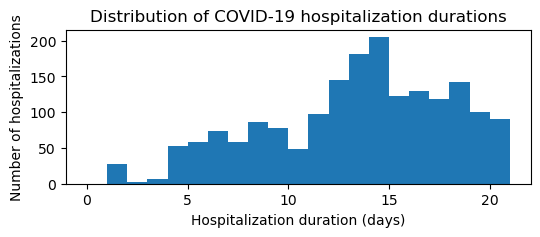

In [36]:
# how long are the recorded hospitalizations?
duration_days = hdf.duration.map(lambda td: td / timedelta(days=1))
print(
    f"Duration (days): median {duration_days.median():.1f}, min {duration_days.min():.1f}, max {duration_days.max():.1f}"
)

fig, ax = plt.subplots(1, 1, figsize=(6, 2))
ax.hist(duration_days, bins=np.arange(0, np.ceil(duration_days.max())))
ax.set_xlabel("Hospitalization duration (days)")
ax.set_ylabel("Number of hospitalizations")
ax.set_title("Distribution of COVID-19 hospitalization durations")
plt.show()

In [37]:
assert np.all(hdf.n_organizations == 1)
assert np.all(hdf.n_providers == 1)

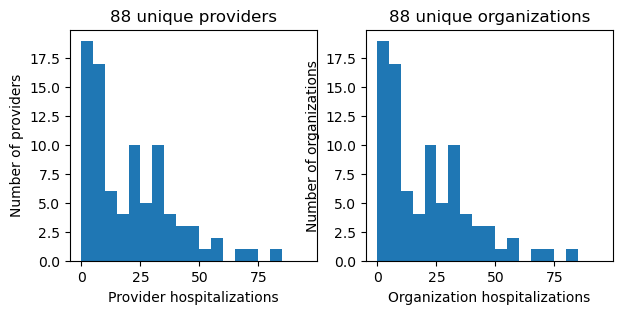

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))

vc = hdf.leading_provider.value_counts()
ax = axes[0]
ax.hist(vc, bins=np.arange(0, vc.max(), 5))
ax.set_xlabel("Provider hospitalizations")
ax.set_ylabel("Number of providers")
ax.set_title(f"{len(vc)} unique providers")

vc = hdf.leading_organization.value_counts()
ax = axes[1]
ax.hist(vc, bins=np.arange(0, vc.max(), 5))
ax.set_xlabel("Organization hospitalizations")
ax.set_ylabel("Number of organizations")
ax.set_title(f"{len(vc)} unique organizations")


plt.show()

In [39]:
# merge in the patient data
# and drop some of the extraneous columns
hdf = (
    hdf.merge(pdf[["Id", "BIRTH", "GENDER", "RACE"]], how="left", left_on="patient", right_on="Id")
    .drop(columns=["Id", "n_providers", "n_organizations", "leading_organization"])
    .rename(columns={"BIRTH": "birthdate", "GENDER": "gender", "RACE": "race"})
)

In [40]:
hdf.sample(n=1)

,patient,startdate,stopdate,is_covid_hospitalization,is_covid_death,leading_provider,duration,birthdate,gender,race
1035,91e79aa4-7a3d-4c6f-8d55-919b0df4df03,2020-03-07 02:24:59,2020-03-21 09:13:59,True,False,999d710b-8227-3749-9a7e-89d84b4a1ae3,14 days 06:49:00,1955-03-24,M,white


In [41]:
# if I were going to do additional analysis here, I would aim to determine if some of these Reasons are COVID-19
# perhaps one would dig closer into trends of these SNOMED disorders in Feb/Mar 2020:
# - acute bronchitis
# - acute viral pharyngitis
# - sinusitis
# - viral sinusitis
sdf = edf[edf.REASONDESCRIPTION.notna()].copy()
sdf["REASONDESCRIPTION"] = sdf.REASONDESCRIPTION.map(str.lower)
sdf[sdf.REASONDESCRIPTION.str.contains("disorder")].groupby("REASONDESCRIPTION").Id.count().sort_values(ascending=False)

REASONDESCRIPTION
chronic congestive heart failure (disorder)                              4629
viral sinusitis (disorder)                                               3698
acute bronchitis (disorder)                                              2382
anemia (disorder)                                                        2370
sinusitis (disorder)                                                     1737
acute bacterial sinusitis (disorder)                                     1536
acute viral pharyngitis (disorder)                                       1480
malignant neoplasm of breast (disorder)                                  1038
seizure disorder                                                          529
alzheimer's disease (disorder)                                            525
primary small cell malignant neoplasm of lung  tnm stage 1 (disorder)     432
streptococcal sore throat (disorder)                                      341
child attention deficit disorder              